In [33]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Flatten, Concatenate

In [2]:
np.random.seed(123)

In [53]:
# Params
n_stores = 3
n_days = 365
store_ids = [f"Store_{i}" for i in range(n_stores)]
time_depth = 21
split_date = pd.to_datetime("2022-10-01")

In [54]:
data = []

for store in store_ids:
    base_sales = np.random.randint(80,120)
    seasonality = 10 * np.sin(np.linspace(0, 2 * np.pi, n_days))
    promo = np.random.binomial(1, 0.2, n_days)
    temp = 15 + 10 * np.sin(np.linspace(0,4 * np.pi, n_days)) + np.random.normal(0,2,n_days)
    noise = np.random.normal(0,5,n_days)
    sales = base_sales + seasonality + 5 * promo - 0.5 * temp + noise

    df_store = pd.DataFrame({
            "Date": pd.date_range("2022-01-01", periods=n_days),
            "Store_ID": store,
            "Sales" : sales,
            "Promo": promo,
            "Temperature": temp
    })

    data.append(df_store)

df = pd.concat(data).reset_index(drop=True)

In [55]:
df.sort_values(["Date","Store_ID"]).head()

,Date,Store_ID,Sales,Promo,Temperature
0,2022-01-01,Store_0,101.140152,0,14.993897
365,2022-01-01,Store_1,105.666502,0,14.652609
730,2022-01-01,Store_2,101.571769,0,15.154818
1,2022-01-02,Store_0,92.795508,0,15.048291
366,2022-01-02,Store_1,106.833007,0,13.875695


In [56]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["Store_ID_encoded"] = le.fit_transform(df["Store_ID"])

df_train = df[df["Date"] < split_date].copy()
df_val = df[df["Date"] >= split_date].copy()

In [57]:
df.sort_values(["Date","Store_ID"]).head()

,Date,Store_ID,Sales,Promo,Temperature,Store_ID_encoded
0,2022-01-01,Store_0,101.140152,0,14.993897,0
365,2022-01-01,Store_1,105.666502,0,14.652609,1
730,2022-01-01,Store_2,101.571769,0,15.154818,2
1,2022-01-02,Store_0,92.795508,0,15.048291,0
366,2022-01-02,Store_1,106.833007,0,13.875695,1


In [58]:
def create_sequences(df, time_steps=14):
    sequences = []
    targets = []
    store_ids = []

    for store_id in df["Store_ID"].unique():
        df_store = df[df["Store_ID"]==store_id].sort_values("Date")
        features = df_store[["Sales", "Promo", "Temperature"]].values
        store_encoded = df_store["Store_ID_encoded"].values[0]

        for i in range(len(features) - time_steps):
            seq = features[i:i+time_steps]
            target = features[i+time_steps][0] # Sales at t+1
            sequences.append(seq)
            targets.append(target)
            store_ids.append(store_encoded)
            
    return np.array(sequences), np.array(targets), np.array(store_ids)

X_train, y_train, store_ids_train = create_sequences(df_train,time_depth)
X_val, y_val, store_ids_val = create_sequences(df_val,time_depth)

In [59]:
X_seq[0]

array([[ 96.73395547,   0.        ,  17.21837897],
       [ 97.46687836,   0.        ,  17.65610187],
       [105.47296197,   0.        ,  16.77973395],
       [104.60549496,   0.        ,  16.90528932],
       [ 95.22110011,   0.        ,  15.21726274],
       [ 99.78980794,   0.        ,  17.77378505],
       [ 99.71626927,   0.        ,  19.42291076],
       [100.34467893,   1.        ,  20.22900481],
       [107.064007  ,   1.        ,  16.62695493],
       [104.34039125,   0.        ,  17.63608405],
       [106.02790665,   1.        ,  17.82406727],
       [102.05496872,   0.        ,  18.33264598],
       [100.09416368,   0.        ,  21.34020804],
       [102.58882601,   0.        ,  16.2015938 ],
       [ 96.80002051,   0.        ,  18.30626837],
       [101.89236542,   1.        ,  24.69641668],
       [101.20737493,   0.        ,  22.8239614 ],
       [ 98.67302774,   0.        ,  20.76499139],
       [100.11434766,   0.        ,  22.98175165],
       [ 97.07718602,   0.     

In [60]:
y

array([116.85997809, 103.94244817,  91.11231017, ..., 107.93276704,
        99.12227511,  99.9014225 ])

In [61]:
df.head(25)

,Date,Store_ID,Sales,Promo,Temperature,Store_ID_encoded
0,2022-01-01,Store_0,101.140152,0,14.993897,0
1,2022-01-02,Store_0,92.795508,0,15.048291,0
2,2022-01-03,Store_0,97.348354,0,14.133241,0
3,2022-01-04,Store_0,108.509199,0,14.580769,0
4,2022-01-05,Store_0,110.462064,1,19.148908,0
5,2022-01-06,Store_0,104.735248,0,16.945001,0
6,2022-01-07,Store_0,106.539010,0,17.868781,0
7,2022-01-08,Store_0,98.890591,0,18.361984,0
8,2022-01-09,Store_0,98.633529,0,19.554102,0
9,2022-01-10,Store_0,106.801875,1,17.857934,0


In [129]:
# Entrées
seq_input = Input(shape=(X_train.shape[1], X_train.shape[2])) # (21,3)
store_input = Input(shape=(1,))

# Embedding magasin
store_embedding = Embedding(input_dim=n_stores, output_dim=4)(store_input)
store_embedding_flat = Flatten()(store_embedding)

# LSTM
x = LSTM(64)(seq_input)

# Fusion
x = Concatenate()([x, store_embedding_flat])
output = Dense(1)(x)

model = Model(inputs=[seq_input, store_input], outputs=output)
model.compile(optimizer="adam", loss="mse")

In [182]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model

# Entrées
seq_input = Input(shape=(X_train.shape[1], X_train.shape[2]))  # (21, 3)
store_input = Input(shape=(1,))

# Embedding magasin
store_embedding = Embedding(input_dim=n_stores, output_dim=4)(store_input)
store_embedding_flat = Flatten()(store_embedding)

# Bloc LSTM enrichi
x = LSTM(128, return_sequences=True)(seq_input)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = LSTM(64)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Fusion avec l'embedding magasin
x = Concatenate()([x, store_embedding_flat])

# Couche dense finale
output = Dense(1)(x)

# Modèle
model = Model(inputs=[seq_input, store_input], outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])


In [183]:
x

<KerasTensor shape=(None, 68), dtype=float32, sparse=False, ragged=False, name=keras_tensor_140>

In [184]:
output

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_141>

In [185]:
model

<Functional name=functional_15, built=True>

In [186]:
model.fit([X_train, store_ids_train], y_train, epochs=250, batch_size=32)

Epoch 1/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 10254.3086 - mae: 100.8118
Epoch 2/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 10155.9922 - mae: 100.4995
Epoch 3/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 10060.5547 - mae: 100.0772
Epoch 4/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9970.6465 - mae: 99.6427
Epoch 5/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9836.7930 - mae: 98.9589
Epoch 6/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9680.1836 - mae: 98.1816
Epoch 7/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9489.6211 - mae: 97.2059
Epoch 8/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9267.0684 - mae: 96.0483
Epoch 9/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9019.4355 - mae: 94.7571
Epoch 10/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8688.1367 - mae: 93.0032
Epoch 11/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8376.1768 - mae: 91.3048
Epoch 12/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - lo

In [187]:
y_pred = model.predict([X_val, store_ids_val])

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


In [188]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred)

print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")


MAE : 4.92
RMSE : 36.08


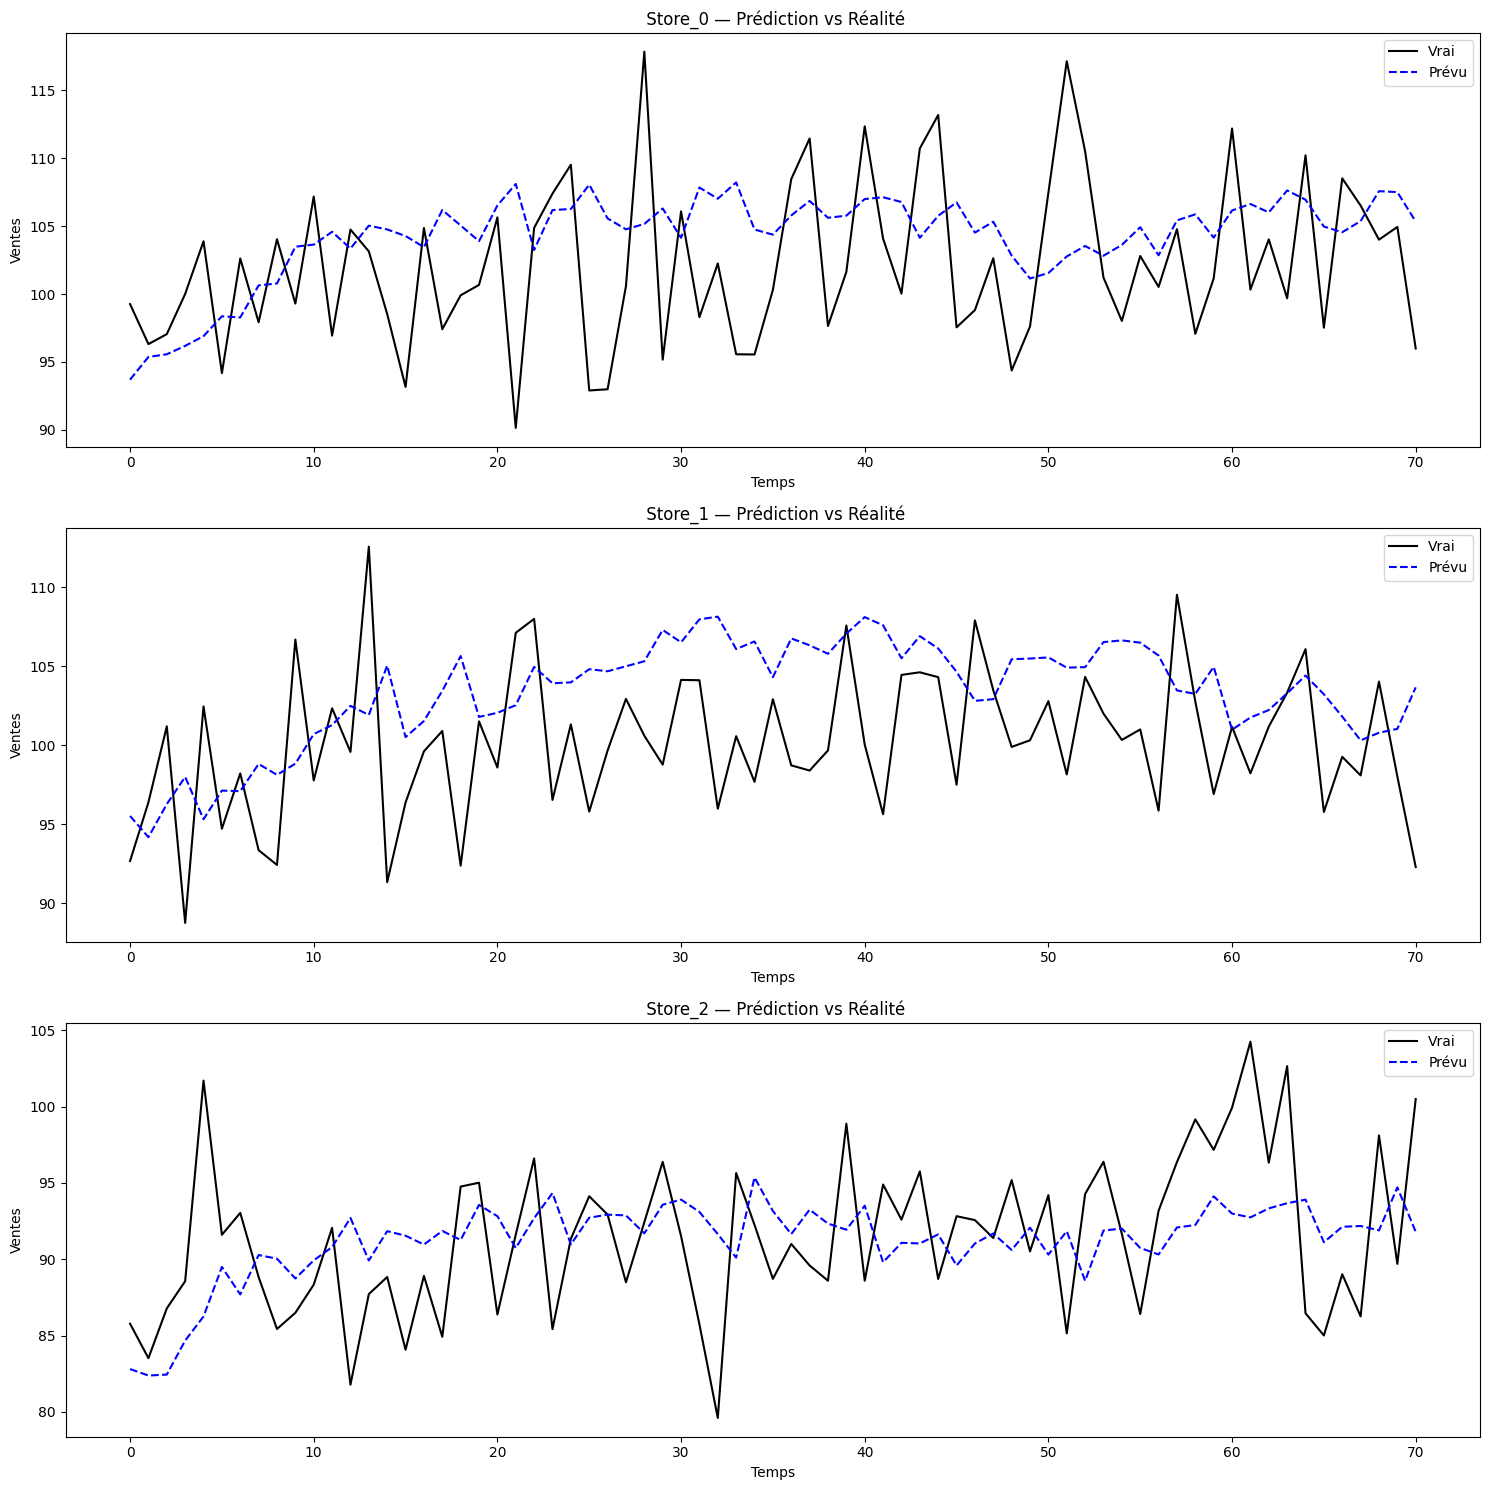

In [189]:
import matplotlib.pyplot as plt

# Récupérer les identifiants encodés
store_names = df["Store_ID"].unique()
store_encoded_map = dict(zip(le.transform(store_names), store_names))

# Tracer les courbes
plt.figure(figsize=(15, 5 * len(store_names)))

for i, store_code in enumerate(np.unique(store_ids_val)):
    # Filtrer les prédictions et vraies valeurs pour ce magasin
    idx = store_ids_val == store_code
    y_true_store = y_val[idx]
    y_pred_store = y_pred[idx].flatten()
    
    # Tracer
    plt.subplot(len(store_names), 1, i + 1)
    plt.plot(y_true_store, label="Vrai", color="black")
    plt.plot(y_pred_store, label="Prévu", color="blue", linestyle="--")
    plt.title(f" {store_encoded_map[store_code]} — Prédiction vs Réalité")
    plt.xlabel("Temps")
    plt.ylabel("Ventes")
    plt.legend()

plt.tight_layout()
plt.show()

In [46]:
# Exemple : prédire pour Store_1
store_name = "Store_1"
store_encoded = le.transform([store_name])[0]
df_store = df[df["Store_ID"] == store_name].sort_values("Date")

# Dernière séquence
last_seq = df_store[["Sales", "Promo", "Temperature"]].values[-21:]
last_seq = last_seq.reshape(1, time_depth, n_stores)
store_input = np.array([[store_encoded]])

# Prédiction
predicted_sales = model.predict([last_seq, store_input])
print(f"Prévision des ventes pour {store_name} : {predicted_sales[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Prévision des ventes pour Store_1 : 50.78
